<a href="https://colab.research.google.com/github/inbalv/tictactoe/blob/master/pagaya_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from operator import index
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Load Dataset
df = pd.read_parquet('data_(1).parquet', engine='pyarrow')
#df.to_csv('train_pagaya.csv')
testset_df = pd.read_parquet('test_set_(1).parquet', engine='pyarrow')
df['issue_month'] = pd.to_datetime(df['issue_date'])
print("\nData Info:")
target_col = 'is_co'

co_loan_sessions = len(df[df['is_co'] > 0])
co_loan_ratio = co_loan_sessions / df.shape[0]
print(f"Co_loans total sessions: {co_loan_sessions}")
print(f"Ratio of co_loans to total sessions: {co_loan_ratio} \n")


#there is no duplicated ids except for 3 sessions
total_count = len(df)
distinct_counts = df.nunique(dropna=True)
missing_counts = df.isnull().sum()

summary = pd.DataFrame({
    'Distinct Count': distinct_counts,
    'Missing Count': missing_counts,
    'Missing%': (missing_counts / total_count) * 100,
    'Data Type': df.dtypes
})

display(summary)

numeric_cols = df.select_dtypes(include=[np.number]).columns

categorical_cols = df.select_dtypes(include=['object']).columns


Data Info:
Co_loans total sessions: 6417
Ratio of co_loans to total sessions: 0.1991311093871218 



,Distinct Count,Missing Count,Missing%,Data Type
months_since_last_inquiry,42,0,0.000000,float64
worst_status_property_trades,10,0,0.000000,float64
months_since_isntl_delinq,257,0,0.000000,float64
months_since_30_60_instl_delinq,86,0,0.000000,float64
percent_funded,23,0,0.000000,float64
loan_amnt,593,0,0.000000,float64
balance_rvlv_last6_months,21998,0,0.000000,float64
debt_to_income,71,1544,4.791311,float64
total_inquiries_last12_months,27,0,0.000000,float64
prcnt_tardes_not_delinq,38,0,0.000000,float64


In [ ]:
print ("********* describe statistics: ***************")

print(" 9999 is set as a none or irrelavant value")
summary_stats = df[numeric_cols].describe()
display(summary_stats.T)

#cleaning the data by let xgboost decide on which split side the irrelent data is suitible
df.replace(9999, np.nan, inplace=True)

********* describe statistics: ***************
 9999 is set as a none or irrelavant value


,count,mean,std,min,25%,50%,75%,max
months_since_last_inquiry,32225.0,3.057254,3.019083,0.0000,1.000,2.00,4.00,6.500000e+01
worst_status_property_trades,32225.0,29.659643,95.194634,0.0000,0.000,1.00,1.00,4.000000e+02
months_since_isntl_delinq,32225.0,63.008192,35.613129,0.0000,39.000,63.00,84.00,5.300000e+02
months_since_30_60_instl_delinq,32225.0,7312.929372,4421.211425,0.0000,71.000,9999.00,9999.00,9.999000e+03
percent_funded,32225.0,0.999952,0.003480,0.7125,1.000,1.00,1.00,1.012500e+00
loan_amnt,32225.0,11571.833896,7158.772075,2000.0000,6000.000,10000.00,15000.00,3.500000e+04
balance_rvlv_last6_months,32225.0,19331.719721,23683.223469,0.0000,5177.000,11714.00,24649.00,5.036230e+05
debt_to_income,30681.0,0.271708,0.125395,0.0000,0.180,0.25,0.35,7.000000e-01
total_inquiries_last12_months,32225.0,1.464763,1.781601,0.0000,0.000,1.00,2.00,3.300000e+01
prcnt_tardes_not_delinq,32225.0,2.905881,2.903688,0.0000,1.000,2.00,4.00,6.400000e+01


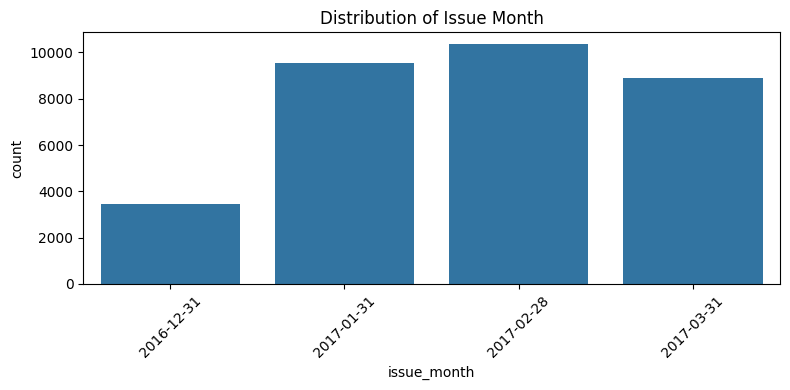

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8, 4))

# Distribution of 'issue_month'
sns.countplot(x='issue_month', data=df)
plt.title('Distribution of Issue Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


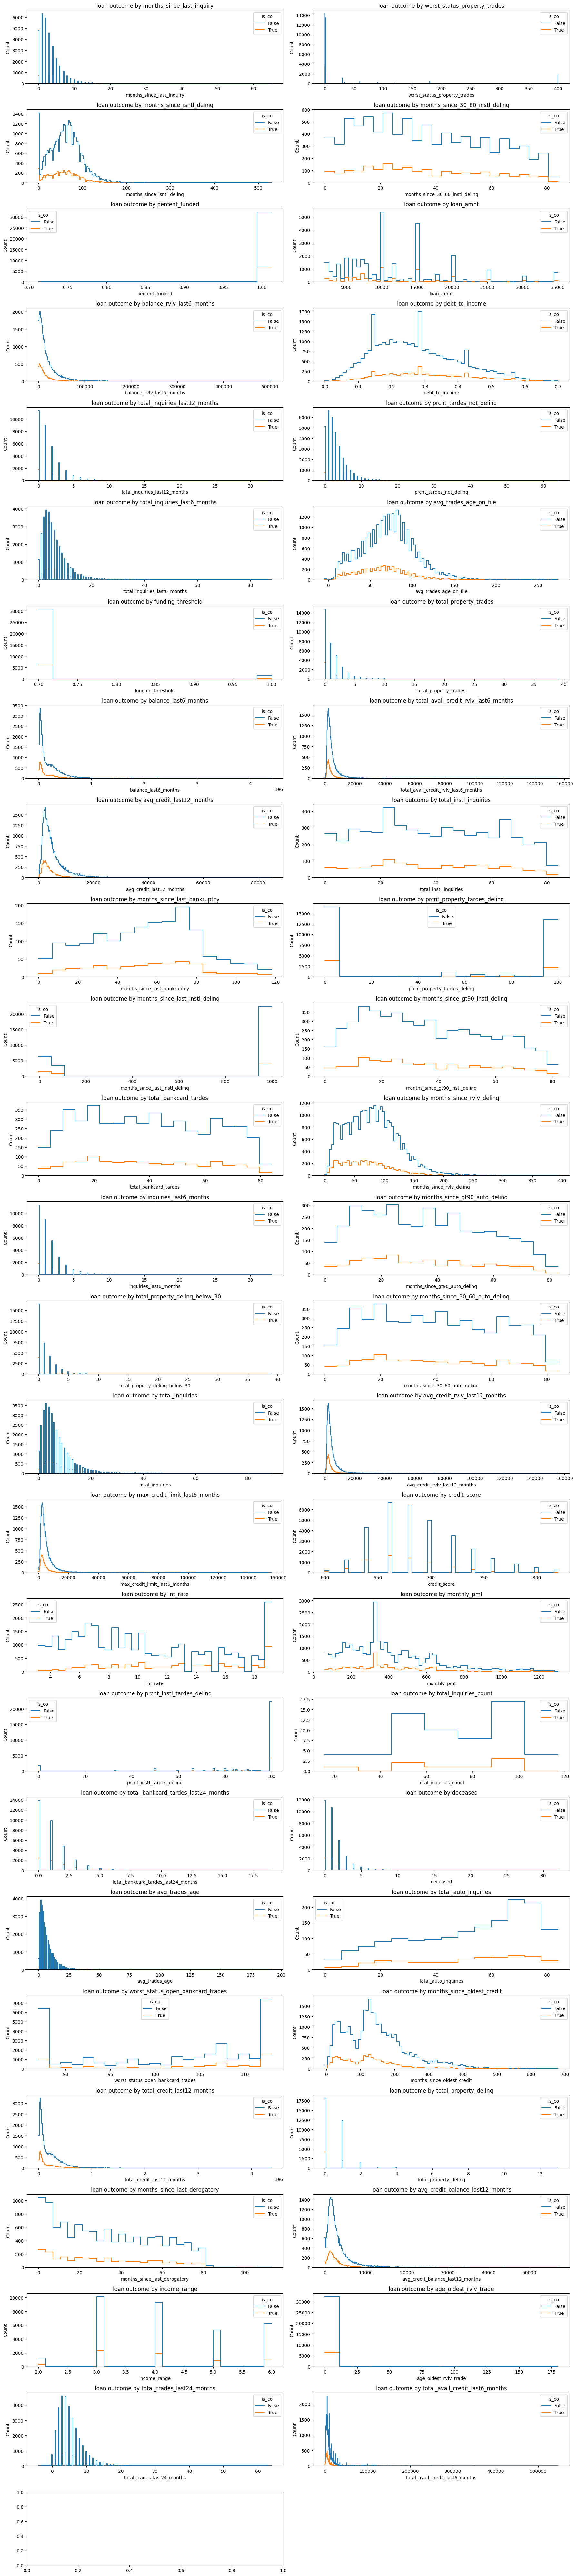

In [ ]:

fig, axes = plt.subplots(nrows=26, ncols=2, figsize=(18, 80))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.histplot(x=col, hue=target_col, data=df, ax=ax, element="step", fill=False ,   multiple="stack")
    ax.set_title(f"loan outcome by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")


if len(numeric_cols) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()


#2. How are the loan's interest rate and credit score affecting the probability of CO?

The analysis shows that both interest rate and credit score strongly predict charge-off (CO) rate.
Loans with higher interest rates exhibit sharply increased CO rates:
loans at high interest have default rates of 25-35% or more, compared to below 5% for those at ~8-10%.

Higher credit scores correlate with lower CO rate. borrowers with scores around 750-800 demonstraye rates near 5%, while those with scores in the 550-600 range have much higher co probabilities.

These findings indicate that higher rates indicate riskier loans, the interest rate is essentially a proxy for the lender’s perceived risk of the loan and credit scores effectively reflect creditworthiness, making both a cyclic affect of co rate. In addition both of those features are settled by the same features that used to predict the co which making it strongly depended.

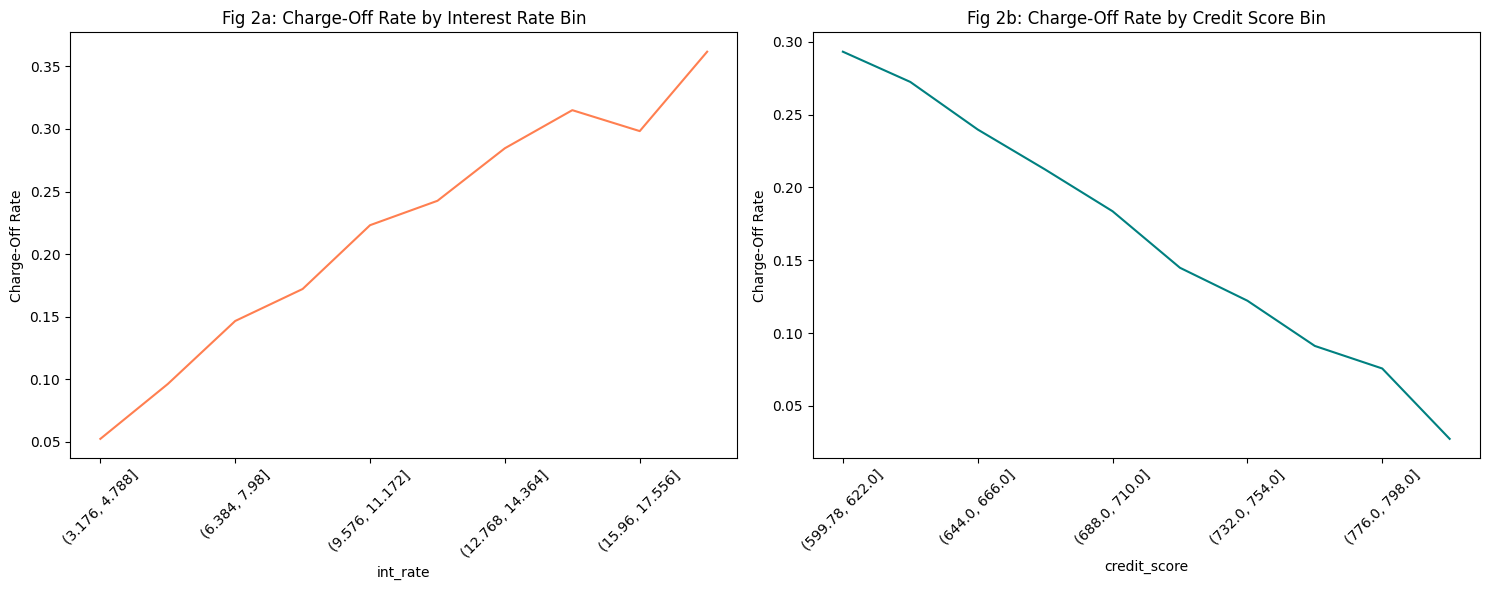

In [ ]:

# Average Charge-Off Rate by Interest Rate and Credit Score bins
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
int_bins = pd.cut(df['int_rate'], bins=10)
int_co = df.groupby(int_bins, observed=True)['is_co'].mean()
int_co.plot(kind='line', ax=axes[0], color='coral')
axes[0].set_title("Fig 2a: Charge-Off Rate by Interest Rate Bin")
axes[0].set_ylabel("Charge-Off Rate")
axes[0].tick_params(axis='x', rotation=45)

score_bins = pd.cut(df['credit_score'], bins=10)
score_co = df.groupby(score_bins, observed=True)['is_co'].mean()
score_co.plot(kind='line', ax=axes[1], color='teal')
axes[1].set_title("Fig 2b: Charge-Off Rate by Credit Score Bin")
axes[1].set_ylabel("Charge-Off Rate")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



# 3. loans issued months

The analysis revealed that January 2017 loans experienced a higher co rate of approximately 19%, compared to 17% for December 2016.

Interestingly, both groups had similar average credit scores  and similar average interest rates and also similar loan amnts - suggesting that these observable factors did not explain the difference in performance.

This suggested that factors such as:
 * Seasonal economic pressures—possibly higher post-holiday financial stress
 * Changes in lending policies that might have resulted in riskier loans being issued in January. we also can see that there is much more loans at Jan 2017 indeicating that the bank might had diffrent policies for that time of the year.

 These findings emphasize the need to consider time-based patterns, like the issue month, when modeling credit risk or making portfolio decisions.
 Unfortunately In this dataset since we only have 4 months it not relevent .Training - Testing datasets are divided by time in order to not predict fast sessions with future sessions.


 Jan 2017
Jan 2017 CO rate: 0.19070059692114358
Jan 2017 count: 9549
Jan 2017 avg credit score: 686.6163996229972, std 42.079353129095836 
Jan 2017 avg interest rate: 10.61519698397738, std 4.7961916331686085
Jan 2017 avg loan_amnt: 11614.294823541733, std 7245.908053283953

 Dec 2016
Dec 2016 CO rate:0.1748109365910413
Dec 2016 count: 3438
Dec 2016 avg credit score: 698.6445607911577, std 41.03293756091901 
Dec 2016 avg interest rate: 8.711631762652704, std 4.649855765133677
Dec 2016 avg loan_amnt: 12357.494299011052, std 7635.606095170406


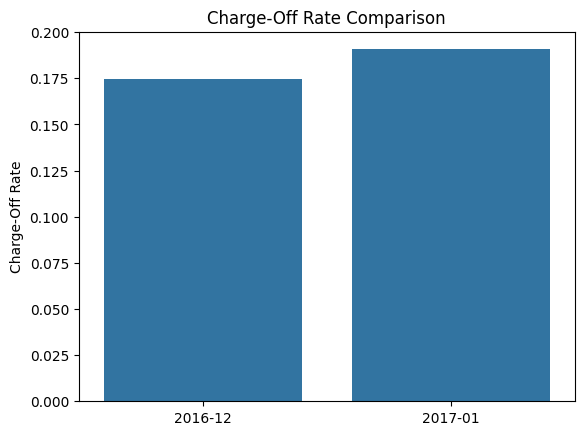

In [ ]:
# 3. loans issued months
import seaborn as sns
import matplotlib.pyplot as plt

if 'issue_date' in df.columns:
    df['issue_month'] = pd.to_datetime(df['issue_date']).dt.to_period("M")
    jan_17 = df[df['issue_month'] == '2017-01']
    dec_16 = df[df['issue_month'] == '2016-12']
    print("\n Jan 2017")
    print(f"Jan 2017 CO rate: {jan_17['is_co'].mean()}")
    print(f"Jan 2017 count: {jan_17['is_co'].count()}")
    print(f"Jan 2017 avg credit score: {jan_17['credit_score'].mean()}, std {jan_17['credit_score'].std()} ")
    print(f"Jan 2017 avg interest rate: {jan_17['int_rate'].mean()}, std {jan_17['int_rate'].std()}")
    print(f"Jan 2017 avg loan_amnt: {jan_17['loan_amnt'].mean()}, std {jan_17['loan_amnt'].std()}")
    print("\n Dec 2016")
    print(f"Dec 2016 CO rate:{dec_16['is_co'].mean()}")
    print(f"Dec 2016 count: {dec_16['is_co'].count()}")
    print(f"Dec 2016 avg credit score: {dec_16['credit_score'].mean()}, std {dec_16['credit_score'].std()} ")
    print(f"Dec 2016 avg interest rate: {dec_16['int_rate'].mean()}, std {dec_16['int_rate'].std()}")
    print(f"Dec 2016 avg loan_amnt: {dec_16['loan_amnt'].mean()}, std {dec_16['loan_amnt'].std()}")

    sns.barplot(x=['2016-12', '2017-01'], y=[dec_16['is_co'].mean(), jan_17['is_co'].mean()])
    plt.title("Charge-Off Rate Comparison")
    plt.ylabel("Charge-Off Rate")
    plt.show()

# Feature Eng

In [ ]:
def impute_debt_to_income(df, loan_amnt_bins=None):

    #Impute missing values in 'debt_to_income' based on 'loan_amnt' and 'income_range'.
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # If no bins are provided, create 4 bins between the min and max of 'loan_amnt'
    if loan_amnt_bins is None:
        loan_amnt_bins = np.linspace(df['loan_amnt'].min(), df['loan_amnt'].max(), num=50)

    # Create a new column for the binned 'loan_amnt'
    df['loan_amnt_bin'] = pd.cut(df['loan_amnt'], bins=loan_amnt_bins, include_lowest=True)

    # Compute the mean 'debt_to_income' for each group defined by 'income_range' and 'loan_amnt_bin'
    group_mean = df.groupby(['income_range', 'loan_amnt_bin'],observed=False)['debt_to_income'].transform('mean')

    # Fill the null values in 'debt_to_income' with the computed group means
    df['debt_to_income'] = df['debt_to_income'].fillna(group_mean)

    # Optionally drop the temporary 'loan_amnt_bin' column
    df.drop(columns='loan_amnt_bin', inplace=True)

    return df, loan_amnt_bins


def create_top20_occupation_feature(df, top20_occupations = None):
    """
    Creates a new feature 'occupation_top20' in the DataFrame. This new feature retains
    the occupation name if it is among the top 20 most frequent occupations; otherwise,
    it assigns 'Other'.

    """
    # Get the top 20 most frequent occupations
    df['occupation'] = df['occupation'].fillna('unknown')

    if top20_occupations is None:
      top20_occupations = df['occupation'].value_counts().nlargest(20).index
      top20_occupations = [x.replace(' ','') for x in top20_occupations]

    # Create the new feature: if the occupation is in the top 20, keep it; otherwise, label it as 'Other'
    df['occupation_top20'] = df['occupation'].apply(
        lambda occ: occ if occ in top20_occupations else 'not_top_20'
    )
    df['occupation_top20'] = df['occupation_top20'].astype('category')

    return df, top20_occupations

def worst_status_features_cat(df, columns = ['worst_status_open_bankcard_trades','worst_status_property_trades']):
    for col in columns:
        df[col] = df[col].astype(str)
        df[col] = df[col].astype('category')
    return df

def time_based_features(df):
  df['issue_month'] = pd.to_datetime(df['issue_date'])
  df['issue_month'] = pd.to_datetime(df['issue_month'], format='%Y-%m')
  df['month'] = df['issue_month'].dt.month
  df['year'] = df['issue_month'].dt.year
  df['quarter'] = df['issue_month'].dt.quarter
  return df


def features_eng(df):
    """
    Clean and Create additional features based on existing ones.
    """

    df['had_derogatory'] = df['months_since_last_derogatory'] >= 1
    df['had_bankruptcy'] = df['months_since_last_bankruptcy'] >= 1
    df['had_30_60_delinq'] = df['months_since_30_60_instl_delinq'] >= 1
    df['had_90_plus_delinq'] = df['months_since_gt90_instl_delinq'] >= 1
    df['had_auto_delinq'] = (df['months_since_gt90_auto_delinq'] >= 1) | (df['months_since_30_60_auto_delinq'] >= 1)
    df['had_any_delinq'] = df['had_30_60_delinq'] | df['had_90_plus_delinq'] | df['had_auto_delinq']

    df['utilization_rate'] = df['balance_rvlv_last6_months'] / (df['total_avail_credit_rvlv_last6_months'] + 1)
    df['credit_usage_ratio'] = df['avg_credit_balance_last12_months'] / (df['total_credit_last12_months'] + 1)
    df['income_weighted_pmt'] = df['monthly_pmt'] / (df['income_range'] + 1)
    df['loan_to_income'] = df['loan_amnt'] / (df['income_range'] + 1)
    df['installment_share'] = df['monthly_pmt'] / (df['loan_amnt'] + 1)

    df['recent_derog'] = (df['months_since_last_derogatory'] < 24)&(df['months_since_last_derogatory'] >= 0)
    df['recent_bankruptcy'] = (df['months_since_last_bankruptcy'] < 24)&(df['months_since_last_bankruptcy'] >= 0)
    df['recent_30_60_delinq'] = (df['months_since_30_60_instl_delinq'] < 24)&(df['months_since_30_60_instl_delinq'] >= 0)
    df['recent_90_plus_delinq'] = (df['months_since_gt90_instl_delinq'] < 24)&(df['months_since_gt90_instl_delinq'] >= 0)
    df['recent_auto_delinq'] = ((df['months_since_gt90_auto_delinq'] < 24)&(df['months_since_gt90_auto_delinq'] >= 0)) | ((df['months_since_30_60_auto_delinq'] < 24)&(df['months_since_30_60_auto_delinq'] >= 0))
    df['recent_any_delinq'] = df['recent_30_60_delinq'] | df['recent_90_plus_delinq'] | df['recent_auto_delinq']

    return df

def take_care_of_missing_data(df):
  df = df.replace(9999, np.nan)
  return df




In [ ]:

#apply features eng trainset
df = take_care_of_missing_data(df)
df, loan_amnt_bins= impute_debt_to_income(df)
df, top20 = create_top20_occupation_feature(df)
df = worst_status_features_cat(df)
df = features_eng(df)
df = time_based_features(df)

#features eng testset

testset_df = take_care_of_missing_data(testset_df)
testset_df, _ = impute_debt_to_income(testset_df, loan_amnt_bins)
testset_df, _ = create_top20_occupation_feature(testset_df, top20 )
testset_df = worst_status_features_cat(testset_df)
testset_df = features_eng(testset_df)
testset_df = time_based_features(testset_df)



In [ ]:
drop_cols = list(set(['deceased','funding_threshold','issue_month','issue_date','id','occupation','borrower_city', 'prcnt_instl_tardes_delinq','total_inquiries_count']))#,'months_since_last_derogatory','months_since_last_','total_inquiries_count',    'months_since_gt90_auto_delinq','months_since_30_60_auto_delinq','months_since_last_bankruptcy','months_since_last_derogatory','total_auto_inquiries','months_since_30_60_instl_delinq','total_instl_inquiries','months_since_gt90_instl_delinq']))
drop_cols =['month','year','quarter']+drop_cols
features = [col for col in df.columns if col not in ['is_co'] + drop_cols]
print("features: \n" )
print(*features, sep='\n')



features: 

months_since_last_inquiry
worst_status_property_trades
months_since_isntl_delinq
months_since_30_60_instl_delinq
percent_funded
loan_amnt
balance_rvlv_last6_months
debt_to_income
total_inquiries_last12_months
prcnt_tardes_not_delinq
total_inquiries_last6_months
avg_trades_age_on_file
total_property_trades
balance_last6_months
total_avail_credit_rvlv_last6_months
avg_credit_last12_months
total_instl_inquiries
months_since_last_bankruptcy
prcnt_property_tardes_delinq
months_since_last_instl_delinq
months_since_gt90_instl_delinq
total_bankcard_tardes
months_since_rvlv_delinq
inquiries_last6_months
months_since_gt90_auto_delinq
total_property_delinq_below_30
months_since_30_60_auto_delinq
total_inquiries
avg_credit_rvlv_last12_months
max_credit_limit_last6_months
credit_score
int_rate
monthly_pmt
total_bankcard_tardes_last24_months
avg_trades_age
total_auto_inquiries
worst_status_open_bankcard_trades
months_since_oldest_credit
total_credit_last12_months
total_property_delinq
mo

In [ ]:

X = df[features]
y = df['is_co']

# Split into train (50%), validation (25%), and test (25%) sets with stratification on 'label'
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=False )
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

print("\nData split sizes:")
print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count
print(f"scale_pos_weight: {scale_pos_weight} \n")

print(f"y_train_fit_sum : {y_train.sum()} , y_train_fit_len: {len(y_train)} , co_ratio: {y_train.sum()/len(y_train)}")
print(f"y_valid_sum : {y_val.sum()} , y_valid_len: {len(y_val)} , co_ratio: {y_val.sum()/len(y_val)}")
print(f"y_test_sum : {y_test.sum()} , y_test_len: {len(y_test)} , co_ratio: {y_test.sum()/len(y_val)}")



Data split sizes:
Train: (16112, 64) Validation: (8056, 64) Test: (8057, 64)
scale_pos_weight: 4.246499511559753 

y_train_fit_sum : 3071 , y_train_fit_len: 16112 , co_ratio: 0.19060327706057598
y_valid_sum : 1676 , y_valid_len: 8056 , co_ratio: 0.2080436941410129
y_test_sum : 1670 , y_test_len: 8057 , co_ratio: 0.20729890764647468


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score, precision_recall_curve, auc
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from tabulate import tabulate

def print_formatted_metrics(y_test, y_pred):
    """
    Print a nicely formatted confusion matrix and classification report.

    Args:
        y_test: Array-like of true labels.
        y_pred: Array-like of predicted labels.
    """
    # Create confusion matrix DataFrame with labels.
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm,
                         index=["Actual Negative", "Actual Positive"],
                         columns=["Predicted Negative", "Predicted Positive"])

    # Print the confusion matrix using tabulate for prettier formatting.
    print("\nConfusion Matrix:")
    print(tabulate(cm_df, headers="keys", tablefmt="psql"))

    # Create the classification report as a DataFrame.
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Print the classification report using tabulate.
    print("\nClassification Report:")
    print(tabulate(report_df, headers="keys", tablefmt="psql"))



def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on the test data using AUC-PR as the main metric.
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    print("ROC AUC Score: {:.4f}".format(roc_auc))
    print("Average Precision (AUC-PR): {:.4f}".format(avg_precision))
    #print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    #print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print_formatted_metrics(y_test, y_pred)
    # Plot Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve (AUC = {:.4f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()


[0]	validation_0-auc:0.71752	validation_1-auc:0.66773
[10]	validation_0-auc:0.75124	validation_1-auc:0.69054
[20]	validation_0-auc:0.75505	validation_1-auc:0.69195
[30]	validation_0-auc:0.75683	validation_1-auc:0.69449
[40]	validation_0-auc:0.75974	validation_1-auc:0.69534
[50]	validation_0-auc:0.76189	validation_1-auc:0.69608
[60]	validation_0-auc:0.76385	validation_1-auc:0.69649
[70]	validation_0-auc:0.76530	validation_1-auc:0.69631
[80]	validation_0-auc:0.76676	validation_1-auc:0.69651
[90]	validation_0-auc:0.76870	validation_1-auc:0.69648
[100]	validation_0-auc:0.77048	validation_1-auc:0.69666
[110]	validation_0-auc:0.77177	validation_1-auc:0.69729
[120]	validation_0-auc:0.77390	validation_1-auc:0.69754
[130]	validation_0-auc:0.77570	validation_1-auc:0.69800
[140]	validation_0-auc:0.77731	validation_1-auc:0.69810
[150]	validation_0-auc:0.77864	validation_1-auc:0.69797
[160]	validation_0-auc:0.78020	validation_1-auc:0.69807
[164]	validation_0-auc:0.78080	validation_1-auc:0.69807
bes

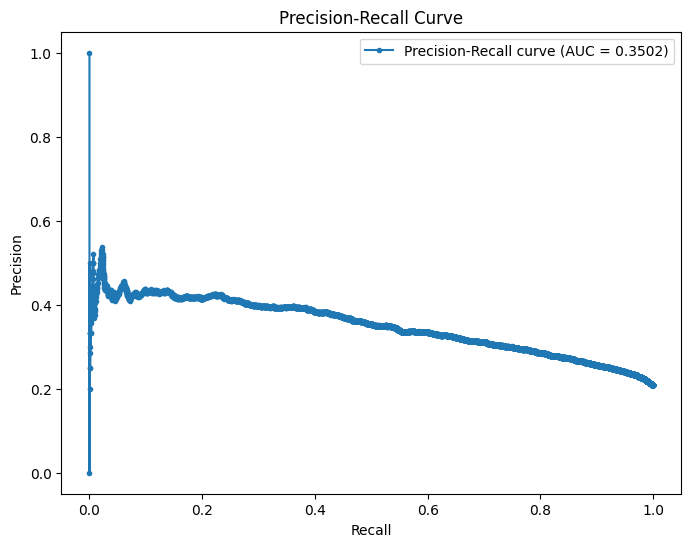


 *********** evaluate_model on trainset_fit: *********** 

ROC AUC Score: 0.7765
Average Precision (AUC-PR): 0.4464

Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
|-----------------+----------------------+----------------------|
| Actual Negative |                 8510 |                 4531 |
| Actual Positive |                  781 |                 2290 |
+-----------------+----------------------+----------------------+

Classification Report:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
|--------------+-------------+----------+------------+--------------|
| False        |    0.91594  | 0.652557 |   0.762135 | 13041        |
| True         |    0.335728 | 0.745685 |   0.463    |  3071        |
| accuracy     |    0.670308 | 0.670308 |   0.670308 |     0.670308 |
| macro avg    |    0.62

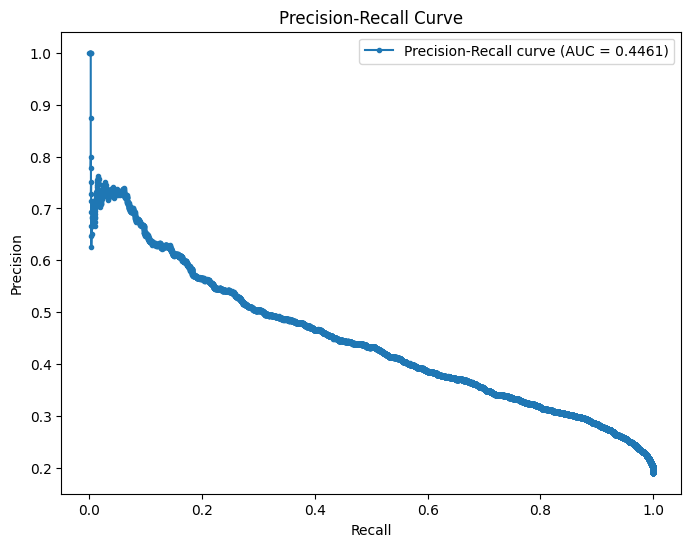

In [ ]:

# Step 6: Build and Train XGBoost Classifier
model = xgb.XGBClassifier(
    n_estimators=1000,      # Large number to allow early stopping
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc' ,
    early_stopping_rounds = 30 ,
    scale_pos_weight = scale_pos_weight,
    #tree_method =  'exact',
    grow_policy = 'depthwise',
    enable_categorical = True,
    booster = 'gbtree',
    base_score= 0.5,
    max_delta_step = 1,
    min_child_weight = 4,
    reg_alpha = 10,
    reg_lambda = 10,

)

# Train the model with early stopping on the validation set
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train),(X_val, y_val)],
    verbose=10
)

print("best_iteration", model.best_iteration)
print("best_score",model.best_score)

print("\n *********** evaluate_model on validationset: *********** \n")

evaluate_model(model, X_val, y_val)

print("\n *********** evaluate_model on trainset_fit: *********** \n")
evaluate_model(model, X_train, y_train)









Test AUC: 0.7007

 *********** evaluate_model on  my testset: ***********  

ROC AUC Score: 0.7007
Average Precision (AUC-PR): 0.3683

Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
|-----------------+----------------------+----------------------|
| Actual Negative |                 3873 |                 2514 |
| Actual Positive |                  533 |                 1137 |
+-----------------+----------------------+----------------------+

Classification Report:
+--------------+-------------+----------+------------+------------+
|              |   precision |   recall |   f1-score |    support |
|--------------+-------------+----------+------------+------------|
| False        |    0.879029 | 0.606388 |   0.717687 | 6387       |
| True         |    0.311422 | 0.680838 |   0.427363 | 1670       |
| accuracy     |    0.62182  | 0.62182  |   0.62182  |    0.62182 |
| macro avg    |  

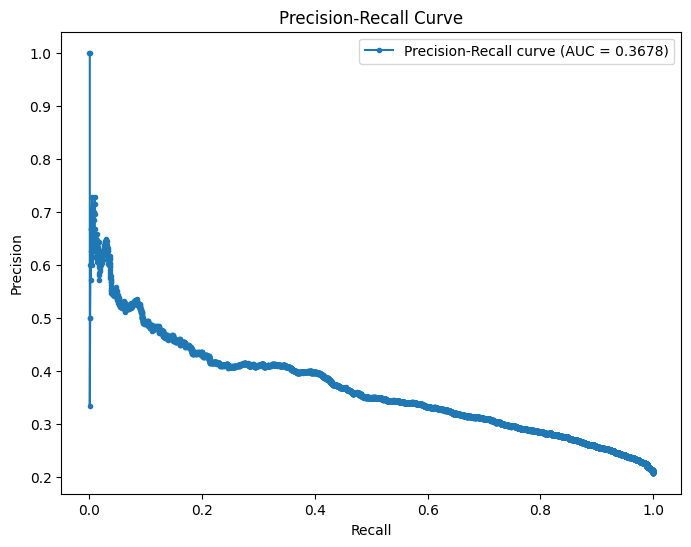

In [ ]:

# Predict probabilities on the test set and calculate AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print("\nTest AUC: {:.4f}".format(auc_score))


print("\n *********** evaluate_model on  my testset: ***********  \n")
evaluate_model(model, X_test, y_test)

<Axes: >

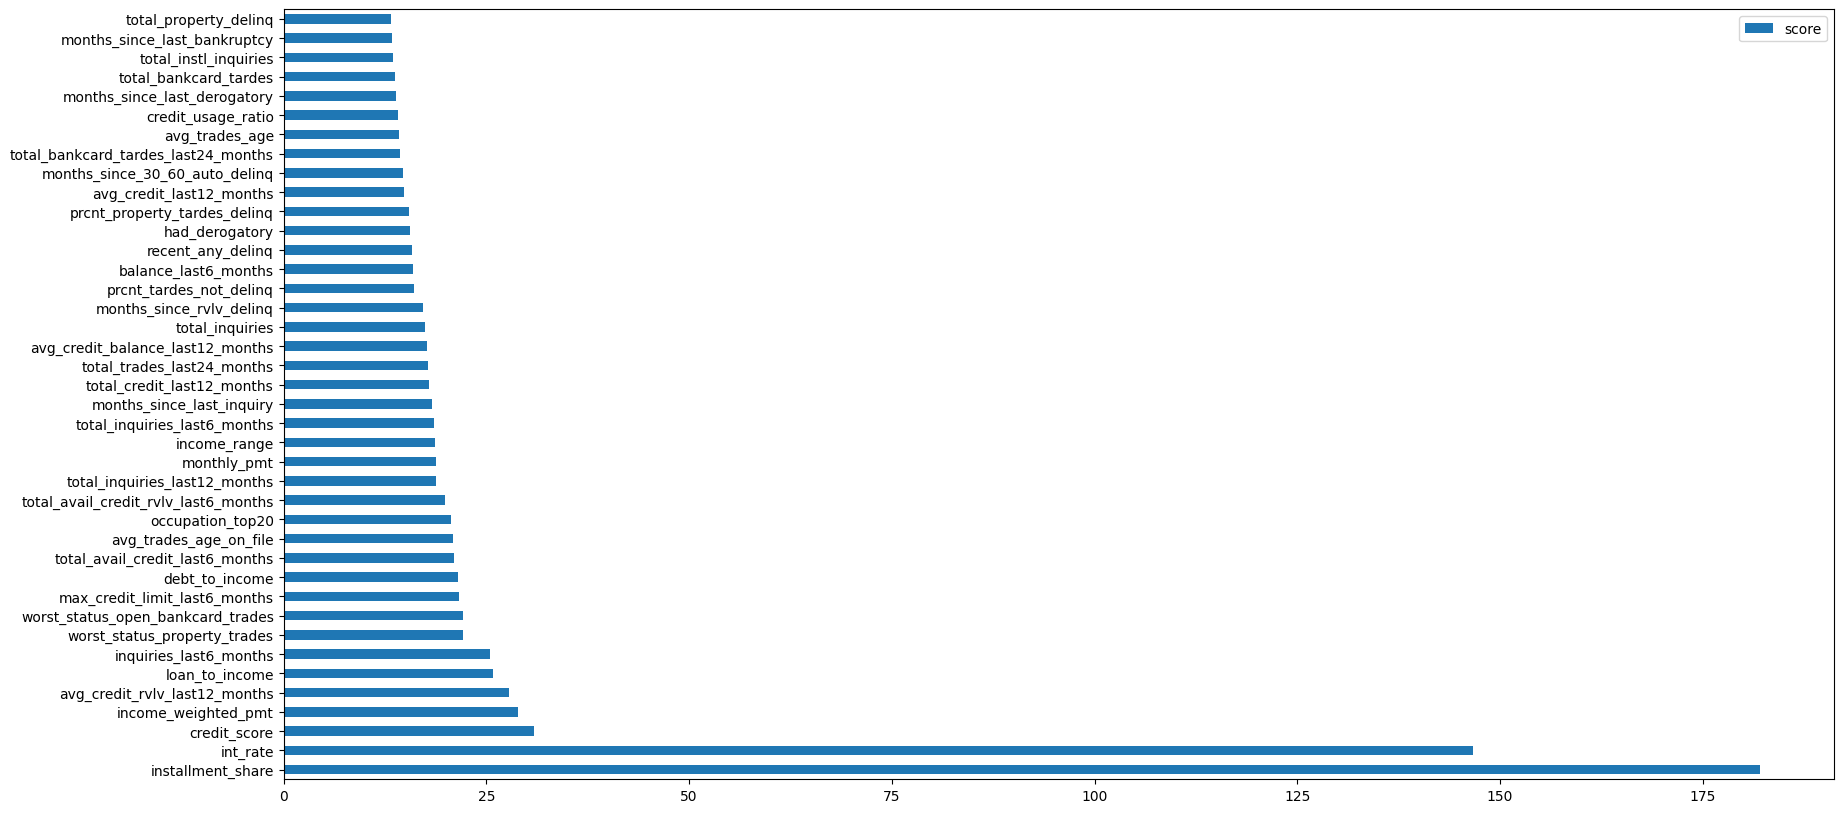

In [ ]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

<Axes: >

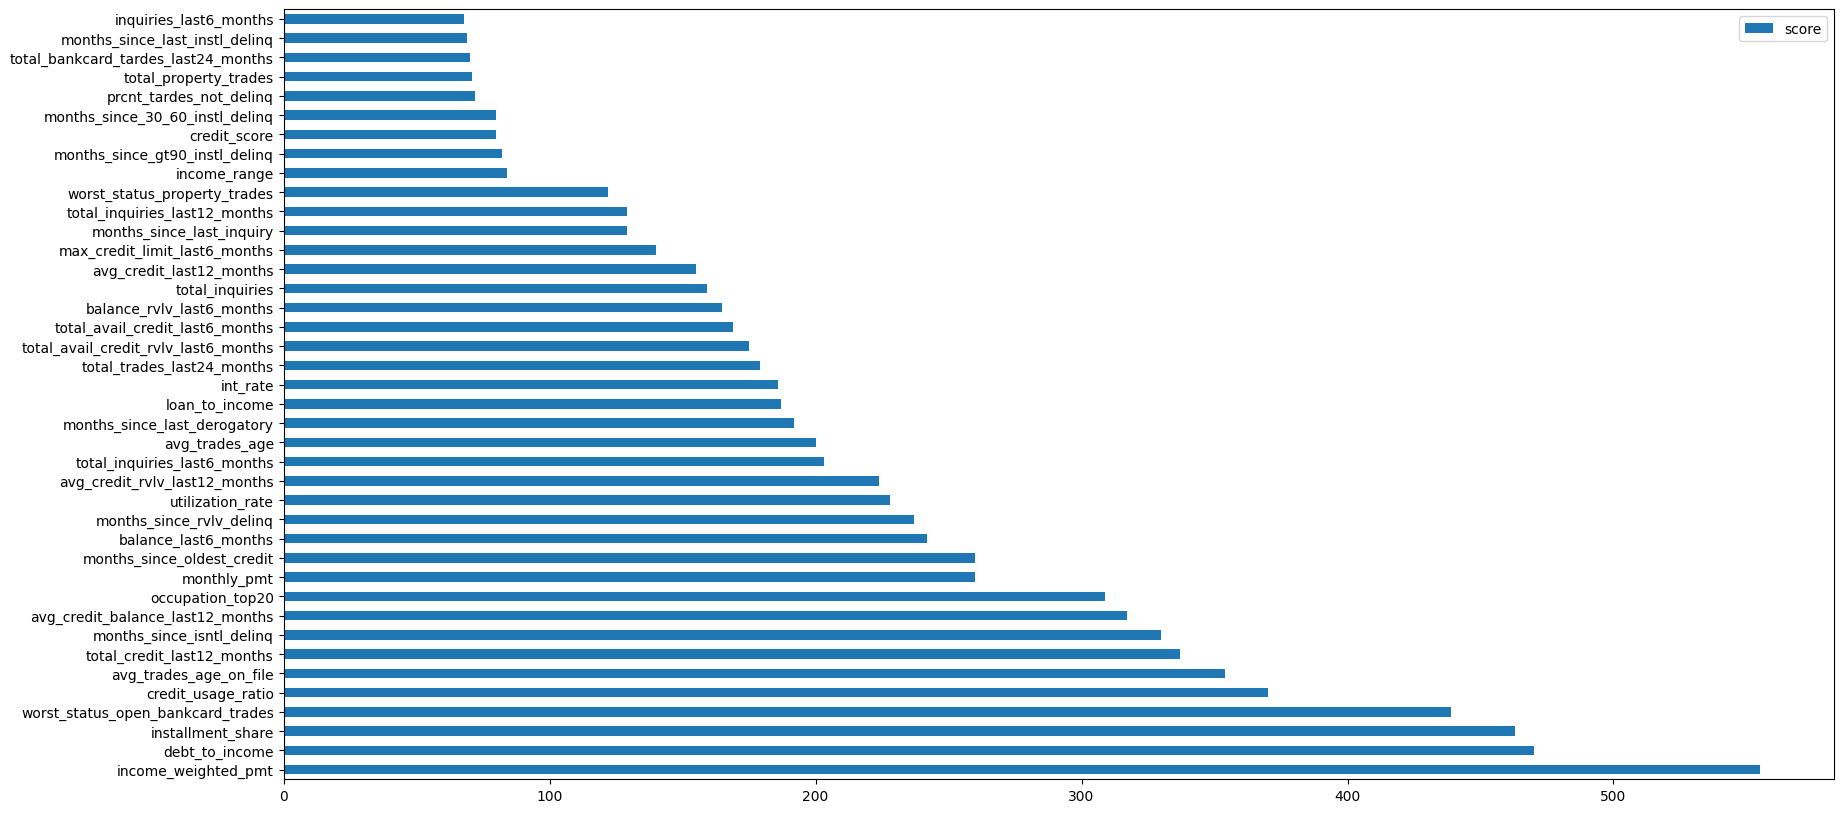

In [ ]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

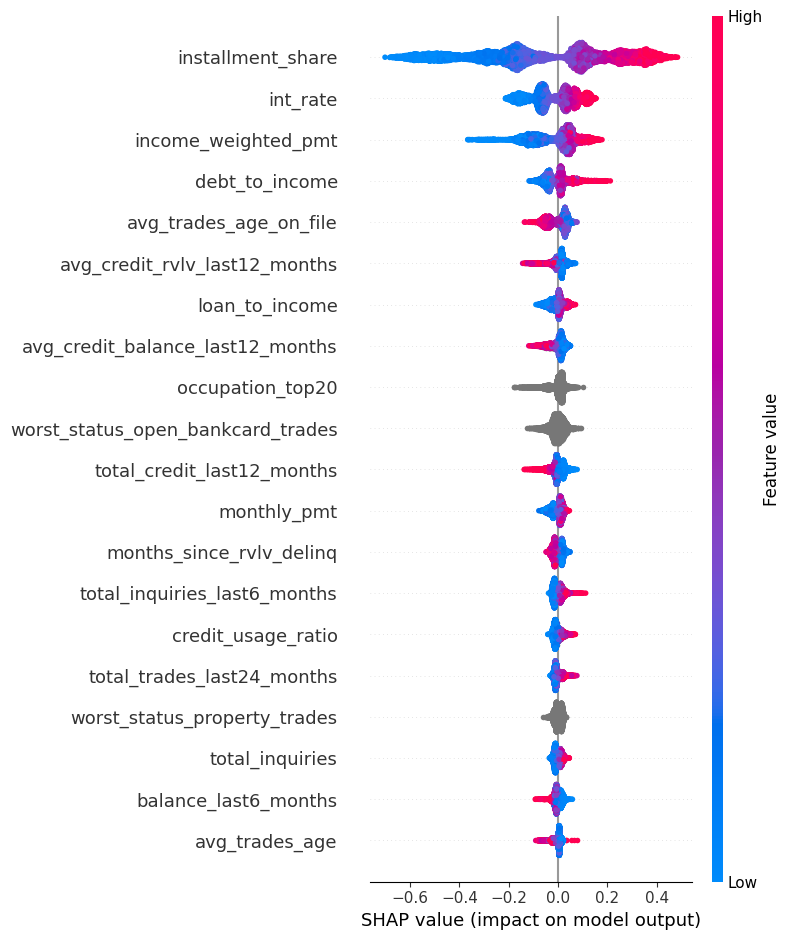

In [ ]:
import shap
import numpy as np

import matplotlib.pyplot as plt


model.get_booster().feature_names == X_train.columns

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=model.get_booster().feature_names, show=False)
plt.tight_layout()
plt.show()


In [ ]:
X_test_mission = testset_df[features]
y_pred_proba_test_mission  = model.predict_proba(X_test_mission)[:, 1]

testset_df['score'] = y_pred_proba_test_mission
testset_df.to_parquet('test_preds.parquet')
testset_df = testset_df.sort_values(by='score', ascending= True)


In [ ]:

display((testset_df[['loan_amnt','int_rate','installment_share','debt_to_income','had_any_delinq','score']]).head(10))

,loan_amnt,int_rate,installment_share,debt_to_income,had_any_delinq,score
id,,,,,,
757800,10800.0,3.960,0.030692,0.150000,False,0.208744
765412,8000.0,3.192,0.030111,0.110000,False,0.209456
751941,10000.0,3.420,0.030283,0.140000,False,0.209709
759011,15000.0,3.780,0.030556,0.230000,False,0.209936
765776,6800.0,3.552,0.030381,0.090000,False,0.210011
762604,3500.0,3.192,0.030106,0.180000,False,0.210079
762338,4500.0,3.780,0.030551,0.110000,False,0.210400
765502,9800.0,3.192,0.030111,0.150000,False,0.210726
768666,30000.0,4.140,0.030830,0.090000,False,0.210799


## 5.1. How would you use your CO classifier to select which loans to buy?

I will approach the loan selection problem methodically: after building the classifier, I will implement a practical strategy to minimize charge-offs within our $15M budget constraint: I will rank all candidate loans by predicted probability*(lowest to highest) and allocate our budget starting with the safest options first.

*calibration might be needed here if we make calculations based on xgb score.

I will also want explicitly prioritize smaller loans to increase diversity -  I will might implement sharp index and try to max it . One tradeoff I've identified: while this conservative strategy minimizes losses, it may not maximize returns since these safer loans typically carry lower interest rates.

# 5.2 maximizing ROI

A loan with a higher interest rate can contribute more profit if it doesn't CO. So to maximize ROI, we should consider the trade-off between risk and reward.
i will try to evaluate the expection of my profit for each loan

 expected_profit  = [(1-p)*(int_rate+1) - 1]**invested_amount

 Implement the knapsack algorithm for this problem by using the invested amonut as "weight" and expected_profit as "value".
 more specifically, sort in descending order the loans by their expected profit, and filling my portfolio (sack) by the highest profit loans as long as i have money to invest in them (removing negative expected protfit loans).

In [ ]:
from typing import List

def select_portfolio(loads_data: pd.DataFrame, total_investment_amount: float)->List[int]:

   loans_data = loads_data.copy()
   loans_data['expected_profit'] = ((1-loans_data['score'])*(loans_data['int_rate']+1) - 1)*loans_data['loan_amnt']
   loans_data = loans_data.sort_values(by='expected_profit', ascending=False)

   # take only positive ex profit loans
   loans_data = loans_data[loans_data['expected_profit'] > 0]

   # do a cumsum over loan_amnt
   loans_data['cum_sum_loan_amnt'] = loans_data['loan_amnt'].cumsum()

   # take rows only up to or equal total_investment_amount
   loans_data = loans_data[loans_data['cum_sum_loan_amnt'] <= total_investment_amount]

   return loans_data.index.tolist(), loans_data['expected_profit'].sum()

portfolio, expected_profit = select_portfolio(testset_df, 15000000)
print("loan ids in portfolio:")
print(portfolio)

portfolio_df = pd.DataFrame(portfolio, columns=['id'])
portfolio_df.to_parquet('portfolio_df.parquet')
print("expected profit from portfolio")
print(expected_profit)



loan ids in portfolio:
['754907', '758657', '765280', '762296', '768167', '756622', '753215', '764233', '759169', '753005', '756865', '758807', '761463', '766642', '756154', '768136', '753988', '768063', '760804', '767238', '766859', '762374', '760187', '767958', '758693', '755262', '758737', '764052', '752544', '757558', '753022', '760682', '752761', '757197', '753968', '766504', '766852', '755644', '768971', '765402', '761418', '765038', '769127', '753323', '760762', '765286', '756090', '754084', '760422', '766884', '769031', '754771', '765501', '755273', '753945', '762759', '755245', '755012', '771474', '769157', '765294', '765157', '759936', '759036', '763306', '771669', '753160', '760130', '760767', '754690', '768015', '757543', '769899', '753694', '767582', '769005', '762039', '755858', '767513', '767510', '761471', '758092', '757762', '752186', '755127', '750337', '765026', '768328', '760283', '770495', '763007', '768527', '765216', '757359', '757766', '754650', '757141', '75609

In [ ]:
expected_profit

np.float64(67501030.67059663)

In [ ]:

import numpy as np
import pandas as pd
from typing import Union

def get_portfolio_roi(ids: Union[pd.Series, pd.Index]) -> float:
    """
    Computes the ROI of a portfolio of loans.

    Args:
        ids (Union[pd.Series, pd.Index]): pd.Series of T/F or a list of ids of loans.

    Returns:
        float: the total ROI of the chosen loans.

    Usage example:
    >>> # get roi of entire test set
    >>> get_portfolio_roi(y_test.index)
    >>>
    >>> # get roi of loans chosen using your model
    >>> y_pred_series = pd.Series(index=y_test.index, data=model.predict(X_test))
    >>> get_portfolio_roi(y_pred_series)

    """
    rois = pd.read_parquet("do_not_read.parquet")
    return rois.loc[ids].pipe(lambda df: np.average(df['ROI'], weights=df['loan_amnt']))

#testset_df.reset_index(inplace=True)
roi = get_portfolio_roi(y_test.index)
print(roi)


0.041219953
